In [1]:
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import os
import logging
import gdown
import random

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import VOCSegmentation
import torchmetrics
import torchvision
import albumentations as A

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import cv2
from PIL import Image

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.io import loadmat
from sklearn.manifold import TSNE
from torchmetrics.functional.classification import multiclass_accuracy
from torchmetrics.classification import MulticlassF1Score, JaccardIndex, MulticlassPrecision, MulticlassRecall, MulticlassAveragePrecision
import pandas as pd

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
logging.basicConfig(level=logging.ERROR)

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:0")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
# ROOT_DIR = '/content/drive/MyDrive/Project/Datasets/ocular-disease-recognition-odir5k'
ROOT_DIR = 'Datasets/ocular-disease-recognition-odir5k/'

In [5]:
IMAGE_FOLDER = ROOT_DIR + '/preprocessed_images'
CSV_PATH = ROOT_DIR + '/dataset_single_eye.csv'
HIST_IMAGE_FOLDER = ROOT_DIR + '/preprocessed_histeq_images'

In [6]:
csv = pd.read_csv(CSV_PATH)

csv = csv[csv['NOT DECISIVE'] == 0]

csv['img_exists'] = csv['Image'].apply(lambda x: os.path.isfile(IMAGE_FOLDER + "/" + x))

# drop the rows for which the file does not exist
csv = csv[csv['img_exists']]

csv.drop(columns = ['ID', 'eye', 'Patient Age',	'Patient Sex', 'NOT DECISIVE', 'img_exists'], inplace = True)
csv

,Image,N,D,G,C,A,H,M,O
0,0_left.jpg,0,0,0,1,0,0,0,0
1,1_left.jpg,1,0,0,0,0,0,0,0
3,3_left.jpg,1,0,0,0,0,0,0,0
4,4_left.jpg,0,0,0,0,0,0,0,1
5,5_left.jpg,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
6995,4686_right.jpg,0,1,0,0,0,0,0,0
6996,4688_right.jpg,0,1,0,0,0,0,0,0
6997,4689_right.jpg,1,0,0,0,0,0,0,0
6998,4690_right.jpg,0,1,0,0,0,0,0,0


In [7]:
# images = [img.split('.', 1)[0] for img in os.listdir(IMAGE_FOLDER) if os.path.isfile(os.path.join(IMAGE_FOLDER, img))]
# print(images[:5])

In [8]:
X = csv['Image'].to_numpy()
Y = csv.drop(['Image'], axis = 1).to_numpy()

print(X.shape)
print(Y.shape)

(6392,)
(6392, 8)


In [9]:
class ODIRDataset(Dataset) :
    
    def __init__(self, X, Y, IMG_FOLDER, HIST_IMG_FOLDER, transform = None) :
        
        '''
        id : list of samples ids as string
        '''

        self.images = X
        self.labels = Y
        self.image_dir = IMG_FOLDER
        self.hist_image_dir = HIST_IMG_FOLDER
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.image_dir, self.images[idx])
        hist_img_path = os.path.join(self.hist_image_dir, self.images[idx])
        
        #image = Image.open(img_path).convert("RGB")
        #hist_image = Image.open(hist_img_path)
        image = torchvision.io.read_image(img_path)
        hist_image = torchvision.io.read_image(hist_img_path)

        labels = torch.Tensor(self.labels[idx]).long()

        if(self.transform != None) :
          image = self.transform(image)
          hist_image = self.transform(hist_image)

        return image, hist_image, labels

In [10]:
def train_val_test_split(dataset, train_percent=0.75, val_percent=0.15, test_percent=0.1, seed=None):
    
    # Given a pytorch Dataset, split it

    assert len(X) == len(Y), "X and Y should have the same length"
    assert round(train_percent + val_percent + test_percent,1) == 1.0, "Train, validation, and test percentages should add up to 1.0"

    if seed is not None:
        np.random.seed(seed)
    
    train_size = int(train_percent * len(dataset))
    val_size = int(val_percent * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # use random_split to split the dataset into train, val, and test sets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

In [11]:
BATCH_SIZE = 2
RANDOM_SEED = 69

In [12]:
ODIR_Dataset = ODIRDataset(X, Y, IMAGE_FOLDER, HIST_IMAGE_FOLDER, transform = None)

train_dataset, val_dataset, test_dataset = train_val_test_split(ODIR_Dataset, 0.9, 0.0, 0.1, RANDOM_SEED)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

5752
0
640


torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


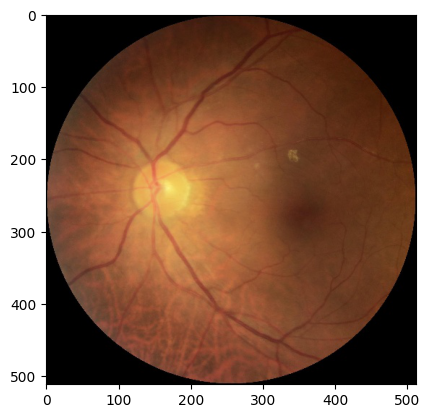

tensor([0, 0, 0, 0, 0, 1, 0, 0])


In [14]:
train_sample, train_hist_sample, train_label = train_dataset[7]

print(train_sample.shape)
print(train_hist_sample.shape)

image_array = np.transpose(train_sample, (1, 2, 0))
plt.imshow(image_array)
plt.show()
# print(train_sample)
print(train_label)

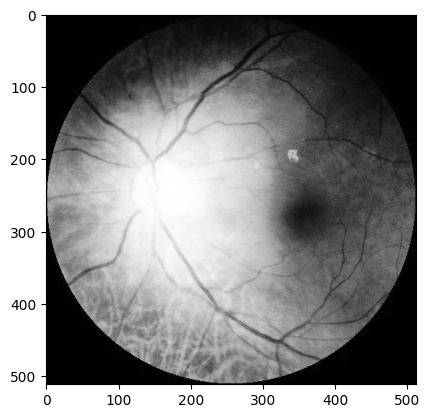

In [15]:
image_array = np.transpose(train_hist_sample, (1, 2, 0))
plt.imshow(image_array, cmap = 'gray')
plt.show()

torch.Size([2, 3, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 8])


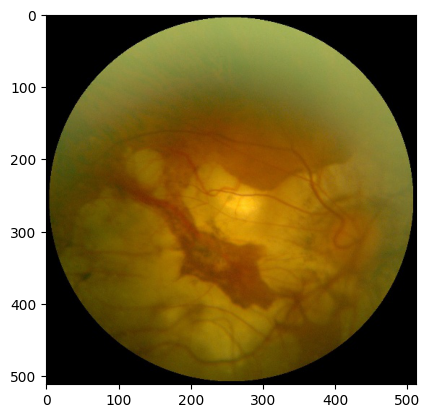

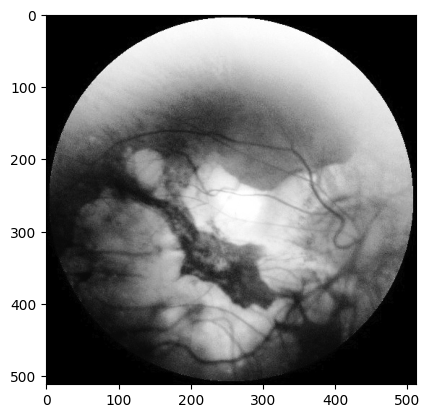

In [16]:
for batch_idx, (data, data_hist, targets) in enumerate((train_dataloader)):

    data = data.to(device=device)
    hist_data = data_hist.to(device=device)
    targets = targets.to(device=device)

    print(data.shape)
    print(hist_data.shape)
    print(targets.shape)

    img1 = data[0] 
    img2 = hist_data[0]

    image_array = np.transpose(img1.to('cpu').numpy(), (1, 2, 0))
    plt.imshow(image_array)

    plt.show()

    image_array = np.transpose(img2.to('cpu').numpy(), (1, 2, 0))
    plt.imshow(image_array, cmap = 'gray')

    plt.show()

    break